## Import Libraries and Custom Dataset Class Definition

Here, a custom dataset class DETRCocoDetection is defined that inherits from the CocoDetection class. This custom dataset applies various data augmentations and pre-processing steps.

This notebook is adopted from the [Hugging Face ropository](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb).


In [106]:
from torchvision.datasets import CocoDetection
import os

import torchvision.transforms as T
from PIL import Image, ImageEnhance, ImageFilter
import random

class DETRCocoDetection(CocoDetection):
    def __init__(self, img_folder, processor, train=True, augment_images=True):
        ann_file = os.path.join(img_folder, "train.json" if train else "test.json")
        super(DETRCocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor
        self.train = train
        self.augment_images = augment_images

    def flip_bbox_horizontal(self, bbox, img_width):
        x_min, y_min, width, height = bbox
        new_x_min = img_width - (x_min + width)
        return [new_x_min, y_min, width, height]
    
    def flip_bbox_vertical(self, bbox, img_height):
        x_min, y_min, width, height = bbox
        new_y_min = img_height - (y_min + height)
        return [x_min, new_y_min, width, height]

    def adjust_bbox_for_crop(self, target, left, top, right, bottom):
        new_target = []
        for ann in target:
            x, y, w, h = ann['bbox']
            
            # Check if the bounding box is inside the crop region
            if x > right or x + w < left or y > bottom or y + h < top:
                continue  # Skip this annotation as it falls outside the crop
            
            # Adjust the bounding box coordinates
            x = max(x - left, 0)
            y = max(y - top, 0)
            w = min(w, right - x)
            h = min(h, bottom - y)
            
            # Update area
            ann['area'] = w * h
            
            # Update the bounding box coordinates
            ann['bbox'] = [x, y, w, h]
            
            new_target.append(ann)
        
        return new_target
    
    def augment_image(self, img, target):
        img_width, img_height = img.size
        
        # Random Horizontal Flip
        if random.random() < 0.3:
            print("Horizontal flip")
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            for ann in target:
                ann['bbox'] = self.flip_bbox_horizontal(ann['bbox'], img_width)

        # Random Vertical Flip
        if random.random() < 0.3:
            print("Vertical flip")
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            for ann in target:
                ann['bbox'] = self.flip_bbox_vertical(ann['bbox'], img_height)

        # Random Crop
        if random.random() < 0.1:
            print("Random Crop")
            left = random.randint(0, int(img.width * 0.3))
            top = random.randint(0, int(img.height * 0.3))
            right = random.randint(int(img.width * 0.7), img.width)
            bottom = random.randint(int(img.height * 0.7), img.height)
            img = img.crop((left, top, right, bottom))
            
            # update bounding boxes
            target = self.adjust_bbox_for_crop(target, left, top, right, bottom)
            
        return img, target

        # Random Color Jitter
        if random.random() < 0.35:
            print("Color Jitter")
            color_transforms = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)
            img = color_transforms(img)

        # Gaussian Blur
        if random.random() < 0.2:
            print("Gaussian Blur")
            img = img.filter(ImageFilter.GaussianBlur(radius=1))
            
        return img, target

    def mixup(self, img1, img2, label1, label2):
        alpha = 2.0  
        lam = np.random.beta(alpha, alpha)
        img = Image.fromarray((lam * np.array(img1) + (1 - lam) * np.array(img2)).astype('uint8'))
        
        # print(label1, label2)
        # Scale the bounding boxes of target2 to match the size of img1
        scale_x = img1.size[0] / img2.size[0]
        scale_y = img1.size[1] / img2.size[1]
        for ann in label2:
            x, y, w, h = ann['bbox']
            ann['bbox'] = [x * scale_x, y * scale_y, w * scale_x, h * scale_y]
            ann['area'] *= (scale_x * scale_y)
    
        # Concatenate the annotations from both targets
        new_target = label1 + label2
    
        return img, new_target
    
    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(DETRCocoDetection, self).__getitem__(idx)

        if self.train and self.augment_images:
            # Mixup of 2 images
            if random.random() < 0.1:
                print("Mix up")
                # Randomly select another image for mixup
                idx2 = random.randint(0, len(self) - 1)
                img2, target2 = super(DETRCocoDetection, self).__getitem__(idx2)
                # Resize img2 to match the dimensions of img1
                img2 = img2.resize(img.size)

                # display(img)
                # display(img2)
    
                # Apply Mixup
                img, target = self.mixup(img, img2, target, target2)
                # display(img)

            temp_rand = random.random()
            if temp_rand >= 0.1 and temp_rand <= 0.3 :
                img, target = self.augment_image(img, target)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

## Initialize Dataset and Data Preprocessor

The `DetrImageProcessor` is used to pre-process images. The `DETRCocoDetection` class is initialized with training and validation datasets.

In [107]:
from transformers import DetrImageProcessor

train_path = '/projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/label-extraction/data/detr_train_test_coco/train/'
val_path = '/projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/label-extraction/data/detr_train_test_coco/test/'
cache_dir = '/projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/label-extraction/data/'

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", rescale_factor=1/200, cache_dir=cache_dir)

train_dataset = DETRCocoDetection(img_folder=train_path, processor=processor, augment_images=False)
# not much of a representative set yet
val_dataset = DETRCocoDetection(img_folder=val_path, processor=processor, train=False, augment_images=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [108]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 118
Number of validation examples: 15


### View Sample Training Images

In [109]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(train_path, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
print(id2label)

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

# uncomment the below line of code to view the chosen image
# image

Image n°110
{0: 'Label'}


## Data Loader Preparation
The data loaders are initialized for training and validation datasets. The `collate_fn` function prepares batches for the model.

In [233]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)

In [234]:
batch = next(iter(train_dataloader))

In [235]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [236]:
pixel_values, target = train_dataset[0]

In [237]:
pixel_values.shape

torch.Size([3, 1267, 800])

In [238]:
print(target)

{'size': tensor([1267,  800]), 'image_id': tensor([0]), 'class_labels': tensor([0, 0]), 'boxes': tensor([[0.7942, 0.0668, 0.3541, 0.0861],
        [0.4520, 0.9251, 0.3541, 0.1273]]), 'area': tensor([30915.1719, 45700.6914]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([9798, 6184])}


## Model Class Definition
The `Detr` class is a wrapper for the DETR model. It extends PyTorch Lightning's `LightningModule` and is responsible for the training and validation logic.

In [254]:
import torch
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection



class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", # can consider "facebook/detr-resnet-101" if we have more labeled data
                                                             revision="no_timm", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        # param_dicts = [
        #       {"params": [n for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
        #       {
        #           "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
        #           "lr": self.lr_backbone,
        #       },
        # ]

        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n 
                          and ("encoder.layers.0" in n 
                              or "encoder.layers.1" in n
                              or "encoder.layers.2" in n
                              or "encoder.layers.3" in n
                              or "encoder.layers.4" in n
                              or "decoder.layers.4" in n
                              or "decoder.layers.5" in n
                              or "bbox_predictor" in n)
                          and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone.conv_encoder.model.embedder" in n 
                             or "stages.0.layers.0" in n 
                             or "stages.0.layers.1" in n
                             or "stages.0.layers.2" in n
                             or "stages.1.layers.0" in n
                             and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]

        print(len(param_dicts[0]["params"]), len(param_dicts[1]["params"]))
        # print(param_dicts[0]["params"], len(param_dicts[1]["params"]))

        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

### Create Model Instance and View Model Parameters

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
named_params = model.named_parameters()
# model_params = [n for n, p in named_params if "backbone" not in n and p.requires_grad]
# model_params = [n for n, p in named_params if "backbone.conv_encoder.model.embedder" in n or "stages.0.layers.0" in n and not p.requires_grad]
# [n for n, p in named_params if "backbone" not in n and "encoder.layers.0" in n and p.requires_grad]
model_params = [n for n, p in named_params]
model_params

In [256]:
model.configure_optimizers()

138 11


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)

In [257]:
# view model output shape
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])
outputs.logits.shape

torch.Size([4, 100, 2])

## Run Model
The training is performed using the `Trainer` class from PyTorch Lightning, with the model initialized above.

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(dirpath=cache_dir, save_top_k=2, monitor="validation_loss", mode="min", save_last=True)
trainer = Trainer(accelerator='gpu', 
                  max_epochs=70,
                  limit_train_batches=10,
                  gradient_clip_val=0.1,
                  log_every_n_steps=5,
                  callbacks=[checkpoint_callback])

trainer.fit(model)
print("Best model path: ", checkpoint_callback.best_model_path)

## Uploading and Downloading Model (Hugging Face)

In [131]:
# Saving model to the disk (a local backup)
model.model.save_pretrained(cache_dir)

### Uploading
Use `push_to_hub` to upload your trained DETR model and processor to your Hugging Face account. Authenticate with the Hugging Face CLI before pushing.

In [259]:
! huggingface-cli login

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /usr4/ds549/kabilanm/.cache/huggingface/token
Login successful


In [260]:
model_name = "spark-ds549/detr-label-detection"

model.model.push_to_hub(model_name)
processor.push_to_hub(model_name)

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spark-ds549/detr-label-detection/commit/0feed29411e5928bf843eeb23743d837b12d5c1a', commit_message='Upload processor', commit_description='', oid='0feed29411e5928bf843eeb23743d837b12d5c1a', pr_url=None, pr_revision=None, pr_num=None)

### Downloading
Use `from_pretrained` to download the model and processor from the Hugging Face hub.

In [261]:
from transformers import DetrImageProcessor, DetrForObjectDetection, DetrModel
import torch

model_path = cache_dir+checkpoint_callback.best_model_path+""

model1 = DetrForObjectDetection.from_pretrained(model_name, id2label=id2label, cache_dir=cache_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor1 = DetrImageProcessor.from_pretrained(model_name, cache_dir=cache_dir)

In [262]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

## Model Evaluation
Here, the model's performance is evaluated using the COCO evaluator, which provides metrics like mAP for object detection tasks.

In [263]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

# push model to GPU
model1.to(device)

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model1(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor1.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)

    # when there are no predictions for an image, this throws and error
    try:
        evaluator.update(predictions)
    except KeyError:
        continue

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/8 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [264]:
# We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[7]

In [265]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 1149, 800])


In [268]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model1(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [269]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model1.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

### View Sample Validation Image with Bounding Boxes

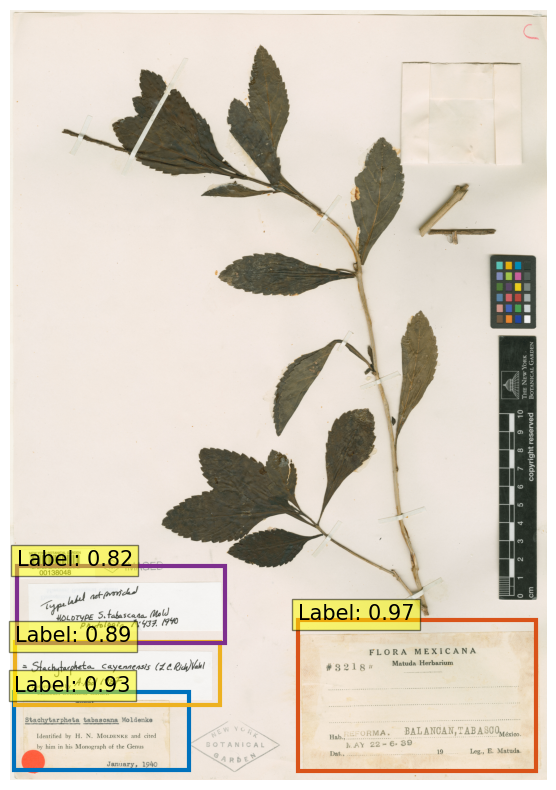

In [270]:
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(val_path, image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor1.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.80)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])